In [20]:
# pip install ipython
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from IPython.display import Image
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import graphviz

In [9]:
'''
员工离职模型代码回顾.
'''

# 1.读取数据与简单预处理
df_stu = pd.read_excel('员工离职预测模型.xlsx')
df_stu = df_stu.replace({'工资': {'低': 0, '中': 1, '高': 2}})

# 2.提取特征变量和目标变量
X_stu = df_stu.drop(columns='离职') 
y_stu = df_stu['离职']

# 3.划分训练集和测试集
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_stu, y_stu, test_size=0.2, random_state=300)

# 4.模型训练及搭建
from sklearn.tree import DecisionTreeClassifier
model_stu = DecisionTreeClassifier(max_depth=3, random_state=300)
model_stu.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=300)

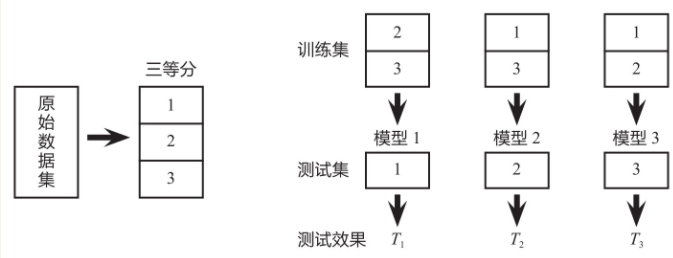

In [10]:
'''
Before we start:
前面讲解决策树模型时就用到了一个很重要的参数max_depth（树的最大深度）,
这种参数又称为超参数。除了max_depth，决策树模型还有一些常用参数,
如criterion（特征选择标准）、min_samples_leaf（叶子节点的最少样本数）等.

如果取值过小，可能会导致模型欠拟合,
如果取值过大，则容易导致模型过拟合,
因此需要一个手段来合理地调节模型参数.

本节将介绍调节模型参数的常用方法GridSearch网格搜索,
以及常与其搭配使用的K折交叉验证。在学习GridSearch网格搜索之前,
首先来了解K折交叉验证的基本原理。

摘自：《Python大数据分析与机器学习商业案例实战》 — 王宇韬  钱妍竹
'''

Image(filename = "kFold_vali.png", width = 700, height = 700)

In [15]:
'''
如果训练集相对较小，则增大K值，这样在每次迭代过程中将会有更多数据用于模型训练,
同时算法时间延长;
如果训练集相对较大，则减小K值，这样可以降低模型在不同的数据块上进行重复拟合性能评估的计算成本,
在平均性能的基础上获得模型的准确评估。

摘自：《Python大数据分析与机器学习商业案例实战》 — 王宇韬  钱妍竹
'''

# 用 K_fold_vali 评估模型,并用更精确的评估结果对模型超参数进行调优.
fold_accuracy = cross_val_score(model_stu, X_stu, y_stu, cv=5)
print(fold_accuracy)
print(fold_accuracy.mean())

[0.96666667 0.96066667 0.959      0.96233333 0.91366667]
0.9524666666666667


In [16]:
# 想以ROC曲线的AUC值作为评估标准，则可以设置scoring参数为'roc_auc'
fold_auc_accuracy = cross_val_score(model_stu, X_stu, y_stu,\
                                    scoring='roc_auc', cv=5)
print(fold_auc_accuracy)
print(fold_auc_accuracy.mean())

[0.97146884 0.9674637  0.96641351 0.97047305 0.95030156]
0.9652241309284616


In [26]:
'''
GridSearch 网格搜索

遍历超参数,用AUC值或accuracy值来评估模型优劣.
如果要同时调节多个模型参数，例如，模型有2个参数，第1个参数有4种可能,
第2个参数有5种可能，所有的可能性可以表示成4×5的网格,
那么遍历的过程就像是在网格（Grid）里搜索（Search).

先尝试单参数调优.
'''

hy_parameters = {'max_depth': np.arange(1,10,2)} 
#loop hyper parameter max_depth 1,3,5,7,9

ori_model = DecisionTreeClassifier()
grid_search = GridSearchCV(ori_model, hy_parameters, scoring='roc_auc', cv=5)
#不设置scoring则默认以accuracy作为衡量标准

grid_search.fit(X_train, y_train)  # 传入测试集数据并开始进行参数调优
print(grid_search.best_params_ ) # 输出参数的最优值

{'max_depth': 7}


In [30]:
'''
输出较优模型(单参优化)
'''

better_model = DecisionTreeClassifier(max_depth=7)  #用max_depth=7重新搭建模型
better_model.fit(X_train, y_train)
better_y_pred = better_model.predict(X_test)

#best_score = accuracy_score(best_y_pred, y_test)
#print(best_score)
#超参数调优时用的是AUC值而非accuracy值,所以看AUC结果更好.

better_y_pred_proba = better_model.predict_proba(X_test)  #查看预测属于各个分类的概率
better_auc_score = roc_auc_score(y_test.values, better_y_pred_proba[:,1])
print(better_auc_score)

0.9795100944033561


In [31]:
'''
现在尝试多超参数同时调优.
'''

mult_hy_parameters = {'max_depth':[5, 7, 9, 11, 13], 'criterion':['gini','entropy'],\
              'min_samples_split':[5, 7, 9, 11, 13, 15]}

ori_model2 = DecisionTreeClassifier()
mult_grid_search = GridSearchCV(ori_model2, mult_hy_parameters,\
                                scoring='roc_auc', cv=5)

mult_grid_search.fit(X_train, y_train)
print(mult_grid_search.best_params_)

{'criterion': 'entropy', 'max_depth': 11, 'min_samples_split': 15}


In [32]:
'''
输出最优模型
'''

best_model = DecisionTreeClassifier(criterion='entropy',\
                                    max_depth=11,min_samples_split=15)
best_model.fit(X_train, y_train)
best_y_pred = best_model.predict(X_test)

best_y_pred_proba = best_model.predict_proba(X_test)  #查看预测属于各个分类的概率
best_auc_score = roc_auc_score(y_test.values, best_y_pred_proba[:,1])
print(best_auc_score)

0.983114741447147


In [33]:
'''
Important:

如果使用GridSearchCV()函数得到的参数最优值是给定范围的边界值,
那么有可能存在范围以外的值使得模型效果更好,
此时需要额外增大范围，继续进行参数调优。
'''

'\nImportant:\n\n如果使用GridSearchCV()函数得到的参数最优值是给定范围的边界值,\n那么有可能存在范围以外的值使得模型效果更好,\n此时需要额外增大范围，继续进行参数调优。\n'

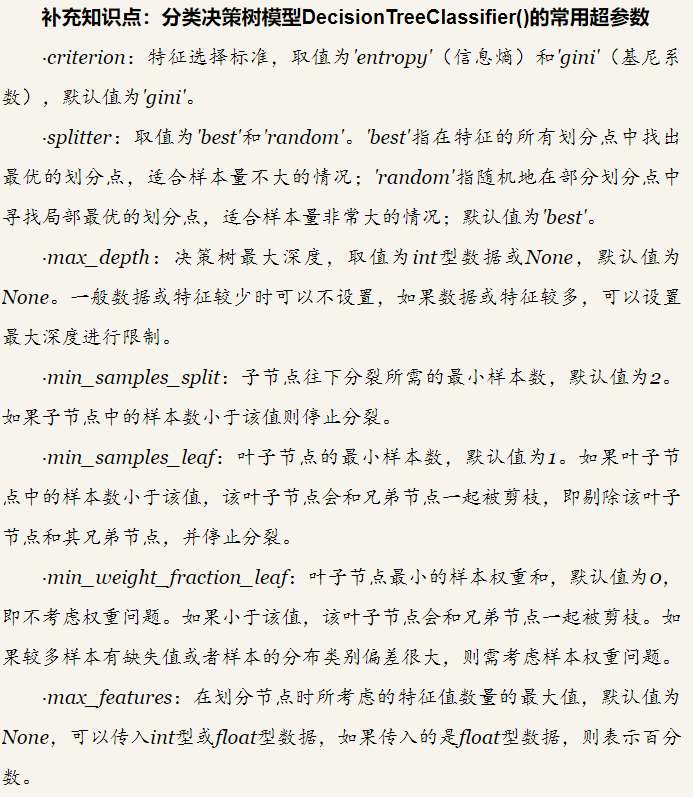

In [37]:
'''
决策树剪枝以防止过拟合:

前剪枝:
从上往下剪枝，通常利用超参数进行剪枝. 
例如，通过限制树的最大深度（max_depth）便能剪去该最大深度下面的节点.

后剪枝:
从下往上剪枝，大多是根据业务需求剪枝.
例如，在违约预测模型中，认为违约概率为45%和50%的两个叶子节点都是高危人群,
那么就把这两个叶子节点合并成一个节点.

摘自：《Python大数据分析与机器学习商业案例实战》 — 王宇韬  钱妍竹
'''

# DecisionTreeClassifier()常见超参数
Image(filename = "dt_hyper_parameters.png", width = 500, height = 500)

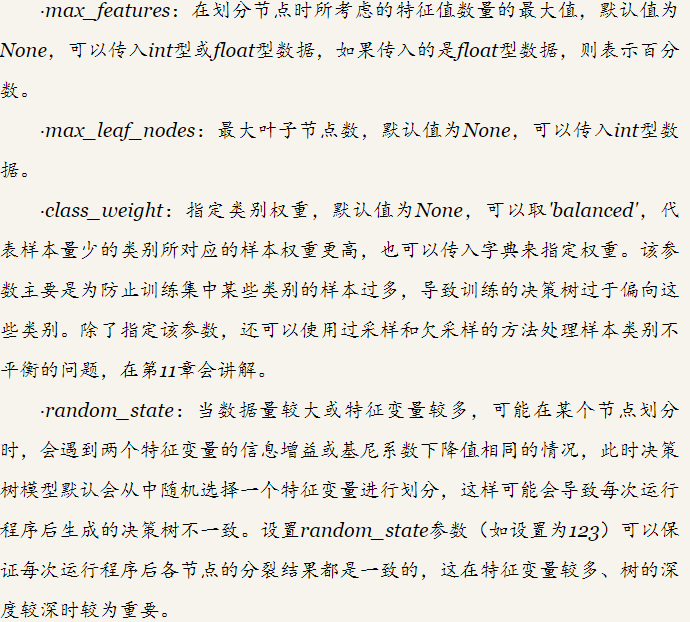

In [38]:
Image(filename = "dt_hyper_parameters2.png", width = 500, height = 500)